In [1]:
import astropy.units as u
from astropy.time import Time
from astroquery.nasa_exoplanet_archive import NasaExoplanetArchive
import tqdm
import string
import matplotlib.pyplot as plt
import numpy as np
from astropy.visualization import time_support
import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)
from collections import defaultdict
from matplotlib.patches import Rectangle
import pandas as pd
import random


In [2]:
targets = {
    'HAT-P-11': 1, 
    'K2-121': 1,
    'K2-136': 3,
    'WASP-43': 1,
    'WASP-107': 1,
    'GJ 9827': 3,
    'K2-266': 4,
    'K2-3': 3,
    'Kepler-138': 3,
    'AU Mic': 1,
    'GJ 357': 1,
    'GJ 3470': 1,
    'K2-18': 1,
    'GJ 436': 1,
    'L 98-59': 3,
    'K2-33':1 ,
    'LTT 1445 A': 1,
    'K2-25': 1,
    'LHS 3844': 1,
    'TRAPPIST 1': 7,
    'LTT 3780': 2,
    'TOI-1130': 2,
    'TOI-1728': 1,
}
transit_times = {}
obs_transit_times = {}
anti_solar = {}
porb = {}

In [3]:
mission_duration = 365.25 #  science mission lifetime
porb_limit = 17 #  this doesn't allow planets with orbital periods longer than this

In [4]:
# this cell talks a few minutes to run
for star in tqdm.tqdm(targets):
    for pletter in string.ascii_lowercase[1:targets[star]+1]:
        planet_properties = NasaExoplanetArchive.query_planet(f"{star} {pletter}", all_columns=True)

        # get relevant planet properties
        epoch = Time(planet_properties['pl_tranmid'], format='jd')
        period = planet_properties['pl_orbper']
        if period > porb_limit * u.day:
            continue
        transit_duration = planet_properties['pl_trandur'] 
        porb[f"{star} {pletter}"] = period
        # Create an EclipsingSystem object for HD 209458
        from astroplan import EclipsingSystem
        planet = EclipsingSystem(primary_eclipse_time=epoch, orbital_period=period,
                                     duration=transit_duration)

        # Calculate next three mid-transit times which occur after ``obs_time``
        obs_time = Time('2025-01-01 00:00')
        n_eclipses = mission_duration * u.day / period + 1
        planet.next_primary_eclipse_time(obs_time, n_eclipses=n_eclipses)

        transit_times[f"{star} {pletter}"] =  planet.next_primary_eclipse_time(obs_time, n_eclipses=n_eclipses)
        
        ast = ((Time('2025-03-21 00:00') +
                   (planet_properties["st_elon"] /(360*u.deg)) *
                   mission_duration * u.day) - (3*mission_duration) * u.day)
        while ast < Time('2025-1-1 00:00'):
                ast += mission_duration * u.day
        anti_solar[f"{star} {pletter}"] = ast

  0%|          | 0/23 [00:00<?, ?it/s]WARNING: AstropyDeprecationWarning: The query_planet function is deprecated and may be removed in a future version.
        Use query_object instead. [warnings]
  4%|▍         | 1/23 [00:05<01:57,  5.36s/it]WARNING: AstropyDeprecationWarning: The query_planet function is deprecated and may be removed in a future version.
        Use query_object instead. [warnings]
100%|██████████| 23/23 [03:43<00:00,  9.73s/it]


In [5]:

# march 21 is approximately ecliptic longitude zero at antisolar
# so let's check for when a planet is +/- 30 ecliptic long of antisolar


In [6]:
# find all the transits in a given observing window
window = 80 #  assume that stars a visible for +/- 80 days either side of antisolar date

100%|██████████| 36/36 [00:09<00:00,  3.71it/s]


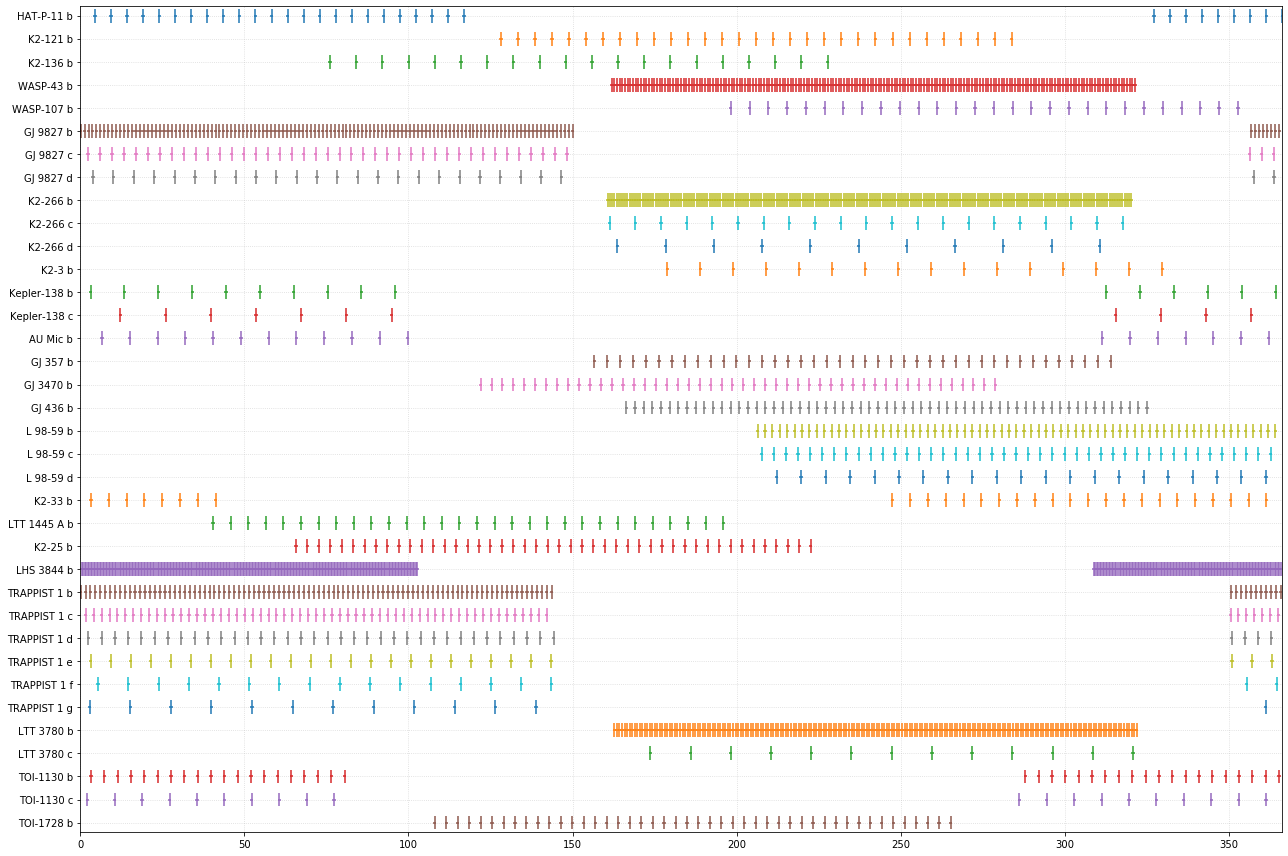

In [7]:
i = len(transit_times)-1

# with time_support():
yticklabels = []
fig, ax = plt.subplots(1, 1, figsize=[18, 12])
for tt in tqdm.tqdm(transit_times):
    ntransits = len(transit_times[tt])
    mask = np.ones(ntransits, dtype=bool)
    for j, ttime in enumerate(transit_times[tt]):
        if (((ttime >= anti_solar[tt] - window) and (ttime <= anti_solar[tt] + window)) or
            ((ttime >= anti_solar[tt] - window - mission_duration) and
             (ttime <= anti_solar[tt] + window - mission_duration)) or 
            ((ttime >= anti_solar[tt] - window + mission_duration) and
             (ttime <= anti_solar[tt] + window + mission_duration))):
            mask[j] = True
        else:
            mask[j] = False
    tx = (transit_times[tt][mask] - Time('2025-01-01 00:00')).jd
    obs_transit_times[tt] = [x for x in tx if (x >0) and (x < mission_duration)]
    ax.errorbar(tx, np.repeat(i, len(tx)), xerr=0.5,
            yerr=0.3,
            ls="",
            marker="")
    yticklabels.append(tt)
    i -= 1
ax.set(yticks=np.arange(len(transit_times)), yticklabels=yticklabels[::-1])
ax.set_xlim(0, 366)
ax.grid(ls=":", alpha=0.5)
# ax.set_xlim(0, 60)
ax.set_ylim(-0.4, len(transit_times)-1+0.4)

plt.tight_layout()

plt.savefig("mock_observing calendar.png", dpi=200)

In [8]:
porb_sorted = sorted(porb.items(), key=lambda x: x[1], reverse=True)

In [9]:
minutes_in_mission = int(mission_duration * (86400/60))
minutes_12_hours = int(60 * 12)
max_transits = 10

In [10]:

scheduled_transit = {}
open_times = np.ones(minutes_in_mission, dtype=bool)
#     for planet, _ in random.sample(porb_sorted, len(porb_sorted)):
for planet, _ in porb_sorted:
    scheduled_transit[planet] = []
    for tt in obs_transit_times[planet]:
        tt_minutes = int(tt * 1440)
        for offset in random.sample(range(-8*60, 8*60, 20), len(range(-8*60, 8*60, 20))):
            if (np.alltrue(open_times[tt_minutes - minutes_12_hours + offset:tt_minutes + minutes_12_hours + offset])
                and 
               (len(scheduled_transit[planet]) < max_transits)):
                open_times[tt_minutes - minutes_12_hours + offset:tt_minutes + minutes_12_hours + offset] = False
                scheduled_transit[planet].append(tt + (offset/1440.))
                break
completeplanets = len(np.nonzero([len(scheduled_transit[x]) == 10 for x in scheduled_transit])[0])
observed_transits = np.sum([len(scheduled_transit[x]) for x in scheduled_transit])




# the code below is for some experiments in optimizing the schedule
# for k in tqdm.trange(1000):
#     scheduled_transit = {}
#     open_times = np.ones(minutes_in_mission, dtype=bool)
# #     for planet, _ in random.sample(porb_sorted, len(porb_sorted)):
#     for planet, _ in porb_sorted:
#         scheduled_transit[planet] = []
#         for tt in random.sample(obs_transit_times[planet], len(obs_transit_times[planet])):
#             tt_minutes = int(tt * 1440)
#             for offset in random.sample(range(-8*60, 8*60, 20), len(range(-8*60, 8*60, 20))):
#                 if (np.alltrue(open_times[tt_minutes - minutes_12_hours + offset:tt_minutes + minutes_12_hours + offset])
#                     and 
#                    (len(scheduled_transit[planet]) < max_transits)):
#                     open_times[tt_minutes - minutes_12_hours + offset:tt_minutes + minutes_12_hours + offset] = False
#                     scheduled_transit[planet].append(tt + (offset/1440.))
#                     break
#     completeplanets = len(np.nonzero([len(scheduled_transit[x]) == 10 for x in scheduled_transit])[0])
#     observed_transits = np.sum([len(scheduled_transit[x]) for x in scheduled_transit])
# #     if observed_transits > 297:
# #         print(np.sum([len(scheduled_transit[x]) for x in scheduled_transit]))
# #         break
#     if completeplanets >= 24:
#         print(completeplanets)
#         break
        
        
            
            

In [12]:
len(np.nonzero([len(scheduled_transit[x]) == 10 for x in scheduled_transit])[0])

22

100%|██████████| 36/36 [00:00<00:00, 200.50it/s]


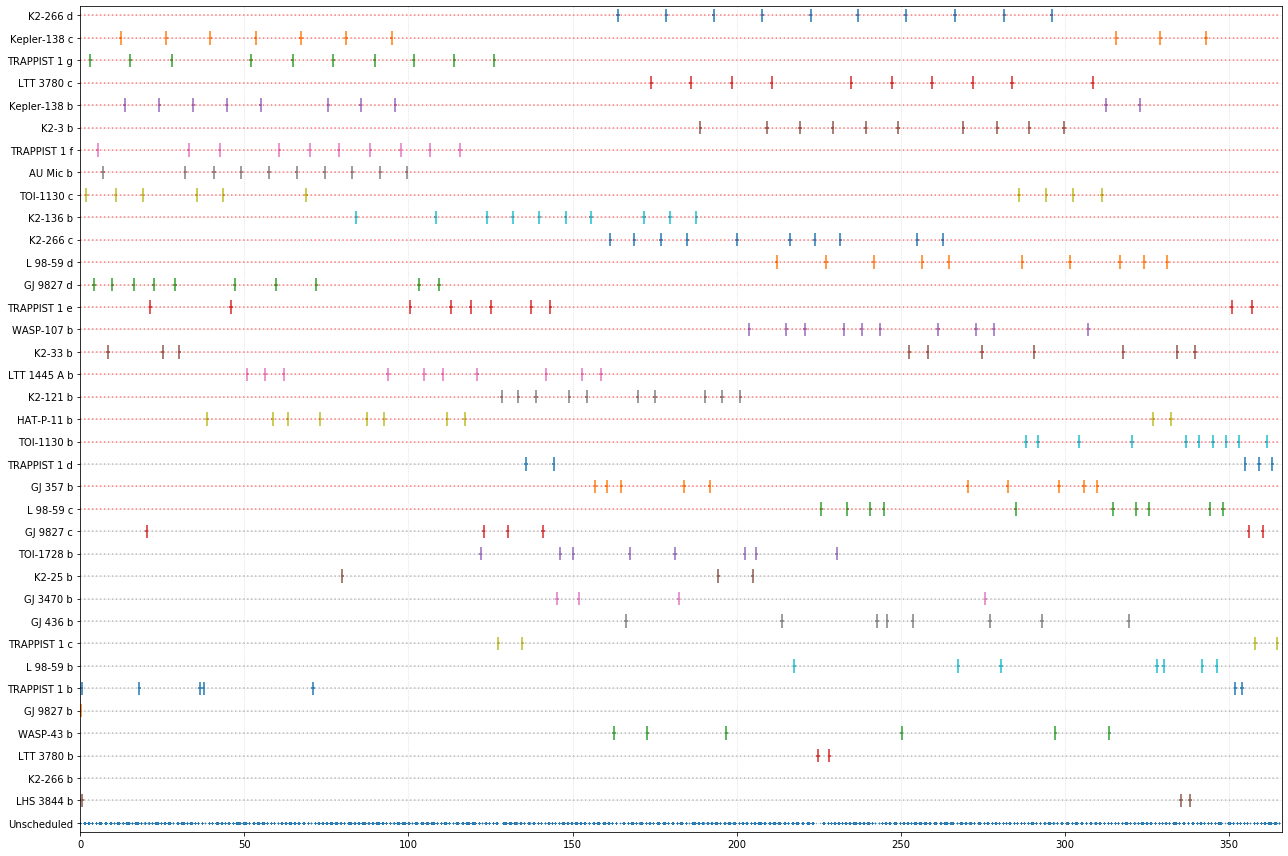

In [14]:
i = len(scheduled_transit)-1
yticklabels = []
fig, ax = plt.subplots(1, 1, figsize=[18, 12])
for planet in tqdm.tqdm(scheduled_transit):
    ntransits = len(scheduled_transit[planet])
    ax.errorbar(scheduled_transit[planet], np.repeat(i, ntransits), xerr=0.5,
            yerr=0.3,
            ls="",
            marker="")
    yticklabels.append(planet)
    if ntransits >= max_transits:
        ax.hlines(i, 0, mission_duration, color='r', ls=':', alpha=0.5)
    else:
        ax.hlines(i, 0, mission_duration, color='grey', ls=':', alpha=0.5)
    i -= 1
ax.scatter(np.where(open_times,np.arange(minutes_in_mission)/1440, np.nan),
         np.repeat(-1, len(open_times)), s=0.1)
yticklabels.append("Unscheduled")
ax.set(yticks=np.arange(-1, len(scheduled_transit)), yticklabels=yticklabels[::-1])
ax.set_xlim(0, 366)
ax.grid(ls=":", alpha=0.5, which="both")
# ax.set_xlim(300, 360)
ax.set_ylim(-1.4, len(scheduled_transit)-1+0.4)

plt.tight_layout()

plt.savefig("mock_year_in_the_life_v1.png", dpi=200)

In [15]:
print(f"Unscheduled: {np.sum(open_times) / 1440} days")
print(f"Total planets: {len(scheduled_transit)}, " +
      f"Fully scheduled planets: {len(np.nonzero([len(scheduled_transit[x]) == 10 for x in scheduled_transit])[0])}")
print(f"Total transits: {np.sum([len(scheduled_transit[x]) for x in scheduled_transit])}")

Unscheduled: 83.25 days
Total planets: 36, Fully scheduled planets: 22
Total transits: 284


In [17]:
# this isn't optimized. Can be much better optimized!

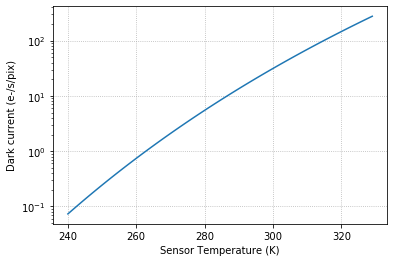

In [285]:
def get_dark_vis(T):
    T0 = 303
    k = 8.62E-5

    Eg0 = 1.1557 - ((7.021E-4 * T0**2)/(1108 + T0))
    SD0 = 40.1

    C = SD0 / (T0**1.5 * np.exp(-Eg0 / (2*k*T0)))
    Eg = 1.1557 - ((7.021E-4 * T**2)/(1108 + T))
    return C * T**1.5 * np.exp(-Eg / (2*k*T))

plt.plot(np.arange(240,330,1), get_dark_vis(np.arange(240,330,1)))
plt.yscale("log")
plt.xlabel("Sensor Temperature (K)")
plt.ylabel("Dark current (e-/s/pix)")
plt.grid(ls=":")
plt.savefig("vis_CIS2521_dark_vs_temp.png", dpi=200)

In [ ]:
plt.plot()